In [1]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import random
import time
import string
from tqdm import tqdm
import os
from transformers import AutoTokenizer
from pathlib import Path
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
os.path

<module 'posixpath' (frozen)>

In [6]:
data = pd.read_csv('../data/raw/dataset(clean).csv')

In [7]:
data.head()

,Emotion,Content,Original Content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat ...,b'RT @Davbingodav: @mcrackins Oh fuck.... did ...
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by th...,i had been feeling a little bit defeated by th...
3,happy,imagine if that reaction guy that called jj kf...,"b""@KSIOlajidebt imagine if that reaction guy t..."
4,disappointed,i wouldnt feel burdened so that i would live m...,i wouldnt feel burdened so that i would live m...


In [8]:
data.shape

(916575, 3)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916575 entries, 0 to 916574
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Emotion           916575 non-null  object
 1   Content           916575 non-null  object
 2   Original Content  916575 non-null  object
dtypes: object(3)
memory usage: 21.0+ MB


## EDA

<Axes: xlabel='Emotion', ylabel='count'>

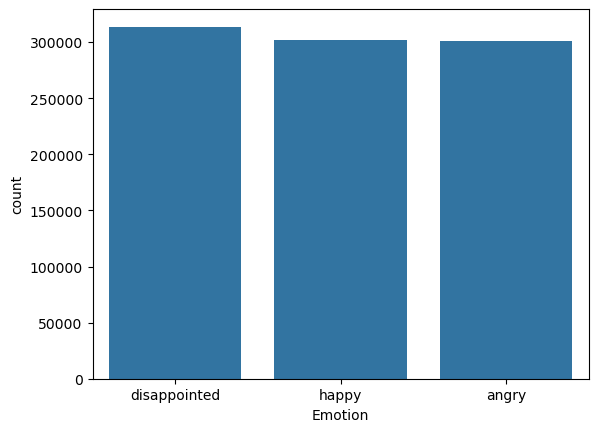

In [10]:
sns.countplot(x=data['Emotion'])

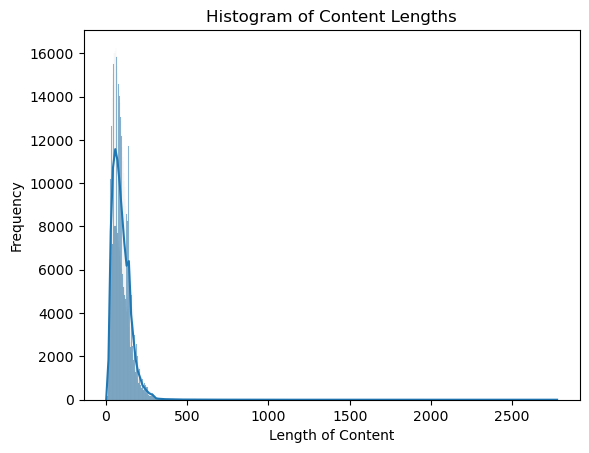

In [11]:
sns.histplot(data=data, x=data['Original Content'].map(len),kde=True)

# Add labels and title
plt.xlabel('Length of Content')
plt.ylabel('Frequency')
plt.title('Histogram of Content Lengths')

# Show the plot
plt.show()

## Pre-processing

In [12]:
class CleanTweets:
    
    def __init__(self,texts):
        self.texts = texts
        self.cleaned_tweets = []
        
    def remove_urls(self,text):
        # Regular expression to match URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+|bit\.ly/\S+|t\.co/\S+|tinyurl\.\S+')
    
        # Replace URLs with an empty string
        return url_pattern.sub('', text)
    
    def remove_numbers(self,text):
        # Regular expression to match numbers
        numbers = re.compile(r'[0-9]+')
        
        # Replace number with an empty string
        return numbers.sub('',text)
    
    def remove_mentions(self,text):
        # Regular expression to match numbers
        mentions = re.compile(r'@[a-zA-Z0-9_]+')
        
        # Replace mentions with an empty string
        return mentions.sub('',text)
    
    def clean_html_tags(self,text):
        # clean html tags off text using bs4
        return BeautifulSoup(text).get_text()
    
    def handle_emoticons(self,text):
        # Regular expression for emoticons
        emoticon_pattern = re.compile(r':([\w-]+):')
        # Replace the emoticons without colon and as a string
        modified_sentence = emoticon_pattern.sub(lambda match: ' '+match.group(1).replace('_', '')+' ', text)
        
        return re.sub(r'\s+', ' ', modified_sentence)
    
    def handle_acronyms(self,text):
        acronym_dict = {'afaik':'as far as i know','ama':'ask me anything','api':'application programming interface','asmr':'autonomous sensory meridian response','bc':'because'
                        ,'b2b':'business-to-business','b2c':'business-to-consumer','b4':'before','bae':'before anyone else',
                       'bff':'best friends forever','brb':'be right back','btaim':'be that as it may','bts':'behind the scenes','bwl':'bursting with laughter',
                       'btw':'by the way','cc':'carbon copy','cpc':'cost per click','csl':'cannot stop laughing','bftba':'do not forget to be awesome',
                       'f2f':'face to face','fb':'facebook','fomo':'fear of missing out','ftfy':'fixed that for you',
                       'ftw':'for the win','gg':'good game','gr8':'great','grwm':'get ready with me',
                       'goat':'greatest of all time','gtg':'got to go','gtr':'got to run','hbd':'happy birthday',
                       'hmb':'hit me back','hifw':'how i feel when','hmu':'hit me up','hth':'happy to help',
                       'idc':'i do not care','idk':'i do not know','ifyp':'i feel your pain','ig':'instagram','ikr':'i know right','ily':'i love you',
                       'im':'instant message','imho':'in my humble opinion','imo':'in my opinion','imu':'i miss you',
                       'irl':'in real life','jk':'just kidding','l8':'late','lamo': 'laughing my ass off','lmk':'let me know','lms':'like my status',
                       'lol':'laughing out loud','lolz':'laughing out loud','mcm':'man crush monday','mfw':'my face when',
                       'mm':'music monday','msg':'message','mtfbwy':'may the force be with you',
                       'nbd':'no big deal','nm':'not much','nsfl':'not safe for life','nsfw':'not safe for work',
                       'nvm':'never mind','oan':'on another note',
                       'omg':'oh my god','omw':'on my way',
                       'ootd':'outfit of the day','op':'original poster','otp':'one true pairing','potd':'photo of the day',
                       'ppc':'pay per click','pm':'private message','ppl':'people','pr':'pagerank','psa':'public service accouncement',
                       'qotd':'quote of the day','qq':'crying','rofl':'rolling on the floor laughing','roflmao':'rolling on the floor laughing my ass off',
                       'roi':'return on investment','rt':'retweet','sc':'snapchat','sem':'search engine marketing','sm':'social media','smh':'shaking my head','sus':'suspicious','tbh':'to be honest',
                       'tbt':'throwback thursday','tfw':'that feeling when','tgif':'thank goodness it is friday',
                       'thx':'thanks','til':'today i learned','tldr':'too long did not read','tmi':'too much information','tntl':'trying not to laugh',
                       'ttyl':'talk to you later','ttyn':'talk to you never','tw':'twitter','txt': 'text','wbu':'what about you ?','w/':'with','wcw':'women crush wednesday',
                       'wfh':'work from home','wdymbt':'what do you mean by that?','wom':'word of mouth','wotd':'word of the day',
                       'wywh':'wish you were here','ygtr':'you got that right','yolo':'you only live once','ysk':'you should know',
                       'yt':'youtube'}
        # Regular expression to match acronyms in text
        pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in acronym_dict.keys()) + r')\b')
        return pattern.sub(lambda match: acronym_dict[match.group(0)], text)
    
    def handle_contractions(self, text):
        CONTRACTION_MAP = {
        "ain't": "is not", "aren't": "are not", "can't": "cannot",
        "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
        "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
        "don't": "do not", "hadn't": "had not",
        "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
        "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
        "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
        "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have",
        "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have",
        "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
        "it'll": "it will", "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
        # Regex to look for contractions to expand
        pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in CONTRACTION_MAP.keys()) + r')\b')
        # Expand contractions
        return pattern.sub(lambda match: CONTRACTION_MAP[match.group(0)], text)

    def remove_punctuations(self,text):
        # Remove punctuations from the text
        translator = str.maketrans("", "", string.punctuation)
        return text.translate(translator)
    
    def handle_hashtags(self,text):
        # Remove hashtag from the text
        hashtag = re.compile(r'#')
        return hashtag.sub('',text)
    
    def clean_tweet(self):
        for text in tqdm(self.texts):
            text = text.replace("\\'", "'")
            if text.startswith("b'") or text.startswith('b"'):
                text = text[2:-1]
            text = text.replace('\n', ' ').replace('\t', ' ').lower()
            rt_pattern = re.compile(r'^\s*rt\s+', re.IGNORECASE)
            text = rt_pattern.sub('', text)
            urls_removed = self.remove_urls(text)
            numbers_removed = self.remove_numbers(urls_removed)
            mentions_removed = self.remove_mentions(numbers_removed)
            html_removed = self.clean_html_tags(mentions_removed)
            hashtag_removed = self.handle_hashtags(html_removed)
            acronyms_expanded = self.handle_acronyms(hashtag_removed)
            contractions_expanded = self.handle_contractions(acronyms_expanded)
            emoticons_cleaned = self.handle_emoticons(contractions_expanded)
            punctuations_removed = self.remove_punctuations(emoticons_cleaned)
            self.cleaned_tweets.append(punctuations_removed.strip())
        return self.cleaned_tweets

In [13]:
clean_tweets = CleanTweets(data['Original Content'].tolist())

In [14]:
data['Cleaned Content'] = clean_tweets.clean_tweet()

  0%|                                                                                                                                                                                | 0/916575 [00:00<?, ?it/s]/var/folders/zh/vbh47d_10r73x8tsyq9ndp9r0000gn/T/ipykernel_53550/4108216800.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text).get_text()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 916575/916575 [01:27<00:00, 10461.37it/s]


In [15]:
# Convert 'Emotion' column to categorical type
data['Emotion'] = data['Emotion'].astype('category')

# Perform one-hot encoding
one_hot = pd.get_dummies(data['Emotion'])

# Drop the original 'Emotion' column from the DataFrame
data = data.drop('Emotion', axis=1)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
data = pd.concat([data, one_hot], axis=1)

In [16]:
data[['angry','disappointed','happy']] = data[['angry','disappointed','happy']].astype(float)

In [17]:
data.to_csv('../data/processed/Cleaned Tweets.csv',index=False)